In [23]:
import re
import vk
import pandas as pd
import time
import pymorphy2
from nltk.tokenize import word_tokenize
import urllib.request
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stop_words import get_stop_words
from collections import Counter
import pymorphy2
from PIL import Image
from wordcloud import WordCloud
stop_words = get_stop_words('ru')
plt.rcParams['figure.figsize'] = 12, 10
plt.rcParams['image.cmap'] = 'viridis'
APP_ID = 6970317
TOKEN = '83d56b3983d56b3983d56b396883bf30f4883d583d56b39df190c359943d1ddc6e0eb44'
VERSION = '5.92'
GROUP = 'vegansurvive'
GROUP_ID = '-114335167'
morph = pymorphy2.MorphAnalyzer()

In [2]:
def get_posts(group, n_posts):
    posts = []
    offsets = list(np.arange(100, n_posts, 100, int))
    for off in offsets:
        req = urllib.request.Request('https://api.vk.com/method/wall.get?domain=%s&offset=%s&count=100&v=%s&access_token=%s'\
                                    % (GROUP, off, VERSION, TOKEN))  
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        data = json.loads(result) 
        posts.extend(data['response']['items'])
        time.sleep(5)
    return posts

In [3]:
posts = get_posts(GROUP, 5000)

In [4]:
def get_comments(group_id, n_comments, posts):
    comments = []
    post_ids = [post['id'] for post in posts]
    offsets = list(np.arange(100, n_comments, 100, int))
    for post_id in post_ids:
        if len(comments)<n_comments:
            req = urllib.request.Request('https://api.vk.com/method/wall.getComments?owner_id=%s&post_id=%s&count=100&v=%s&access_token=%s'\
                                        % (group_id, post_id, VERSION, TOKEN))  
            response = urllib.request.urlopen(req)
            result = response.read().decode('utf-8')
            data = json.loads(result) 
            comments.extend(data['response']['items'])
            time.sleep(5)
        else:
            break
    return comments

In [5]:
comments = get_comments(GROUP_ID, 2000, posts)

### Построение графиков

In [6]:
def tokenize(s):
    s = s.lower()
    s = re.sub('ё', 'е', s)
    s = ' '.join(re.findall('[а-я]+',s))
    s = ' '.join([word for word in s.split() if word not in stop_words])
    return s

def lemmatize(s):
    s = s.lower()
    s = s.split()
    s = [morph.parse(word)[0].normal_form for word in s] #лемматизация при помощи модуля pymorphy
    s = ' '.join([word for word in s if word not in stop_words])
    return s

def plot_most_common(texts, x_label, y_label, title):
    text = ' '.join(texts)
    text_wordcount = Counter(text.split()).most_common(30)
    labels = [word[0] for word in text_wordcount]
    values = [word[1] for word in text_wordcount]
    plot = sns.barplot(x = labels, y = values)
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    plt.title(title, fontsize=15)
    plt.xticks(rotation=35, fontsize = 10)
    plt.savefig(title+'.png',dpi=200)
    plt.show()

In [29]:
df = pd.DataFrame.from_dict(posts)[['id', 'text', 'signer_id']]
df_comments = pd.DataFrame.from_dict(comments)[['post_id', 'from_id', 'text']]
df_comments.dropna(inplace=True)
df['text'] = df['text'].apply(tokenize)
df_comments['text'] = df_comments['text'].apply(tokenize)
df_comments['post_id'] = df_comments['post_id'].map(int).map(str)
df_comments['from_id'] = df_comments['from_id'].map(int).map(str)
df['id'] = df['id'].map(str)
df['length'] = df['text'].apply(lambda x: len(x.split()))
df_comments['length'] = df_comments['text'].apply(lambda x: len(x.split()))

df['lemmas'] = df['text'].apply(lemmatize)
df_comments['lemmas'] = df_comments['text'].apply(lemmatize)

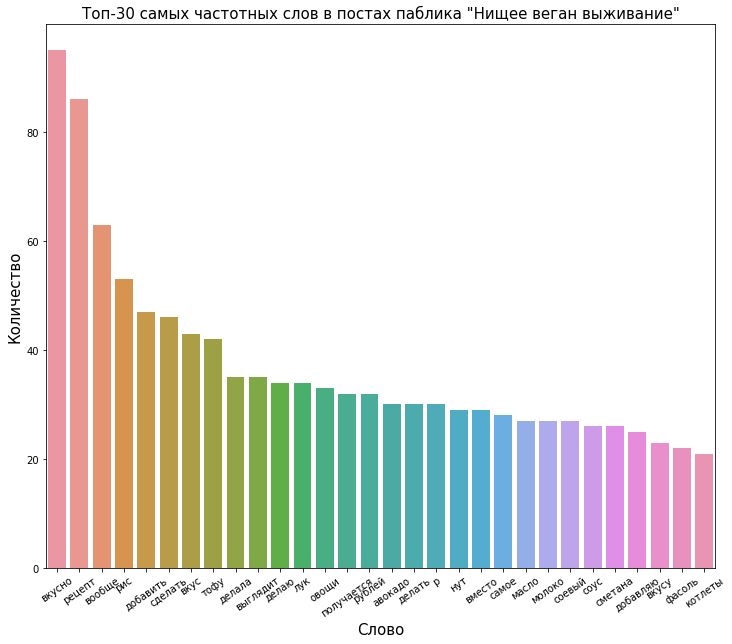

In [30]:
plot_most_common(df_comments['text'], 'Слово', 'Количество', 'Топ-30 самых частотных слов в постах паблика "Нищее веган выживание"')

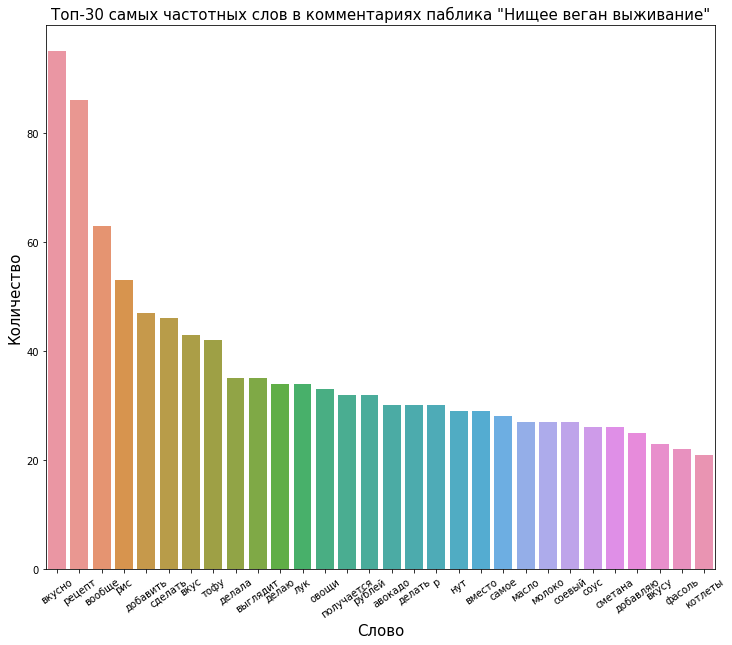

In [31]:
plot_most_common(df_comments['text'], 'Слово', 'Количество', 'Топ-30 самых частотных слов в комментариях паблика "Нищее веган выживание"')

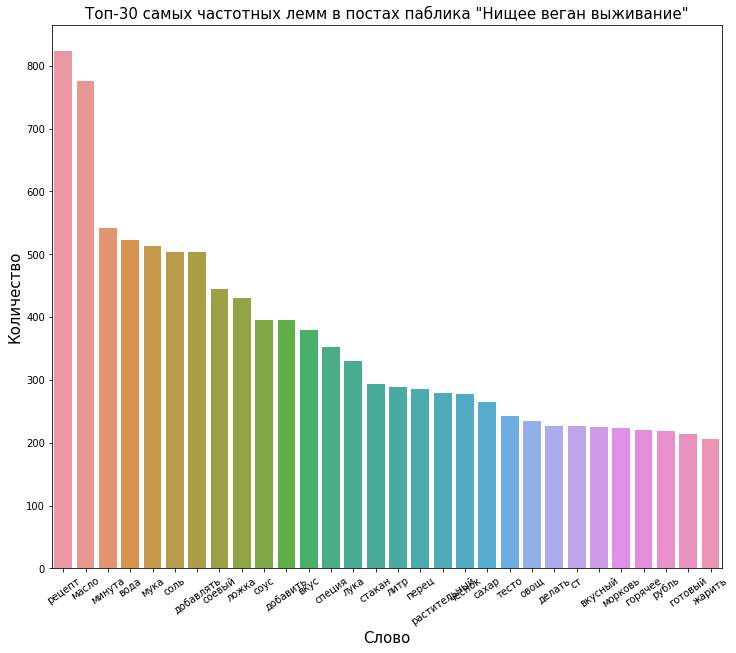

In [32]:
plot_most_common(df['lemmas'], 'Слово', 'Количество', 'Топ-30 самых частотных лемм в постах паблика "Нищее веган выживание"')

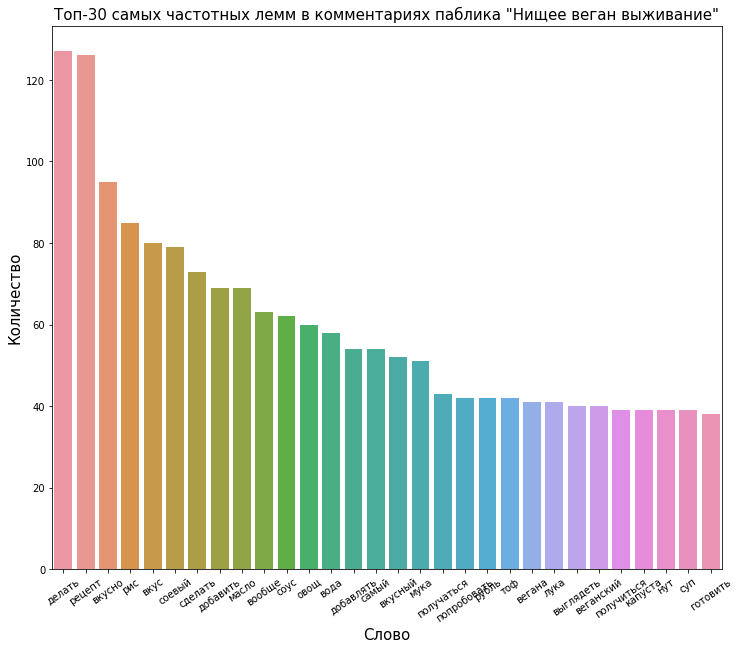

In [33]:
plot_most_common(df_comments['lemmas'], 'Слово', 'Количество', 'Топ-30 самых частотных лемм в комментариях паблика "Нищее веган выживание"')

### График зависимости длины поста от средней длины комментария

In [12]:
averages = []
for i in df_comments['post_id'].unique():
    averages.append((i, np.average(df_comments[df_comments['post_id']==i]['length'])))

In [13]:
df_to_plot = df[df['id'].isin(df_comments['post_id'])]

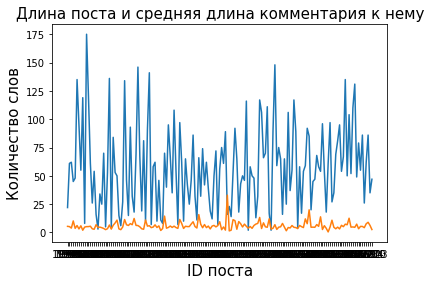

In [14]:
sns.lineplot(x = df_to_plot['id'], y = df_to_plot['length'])
sns.lineplot(x = [str(a[0]) for a in averages], y = [a[1] for a in averages])
plt.xlabel('ID поста', fontsize=15)
plt.ylabel("Количество слов", fontsize=15)
plt.title('Длина поста и средняя длина комментария к нему', fontsize=15)
plt.show()

### Создаем облака слов

In [15]:
def generate_wordcloud(corpus):
    wordcloud = WordCloud(width=1200, height=1200, margin=0).generate(' '.join(corpus))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.rcParams["figure.figsize"] = (30,30)
    plt.show()
    plt.savefig('wordcloud.png')

In [16]:
corpus = ' '.join(df['lemmas']) + ' ' + ' '.join(df_comments['lemmas'])
corpus = corpus.split()

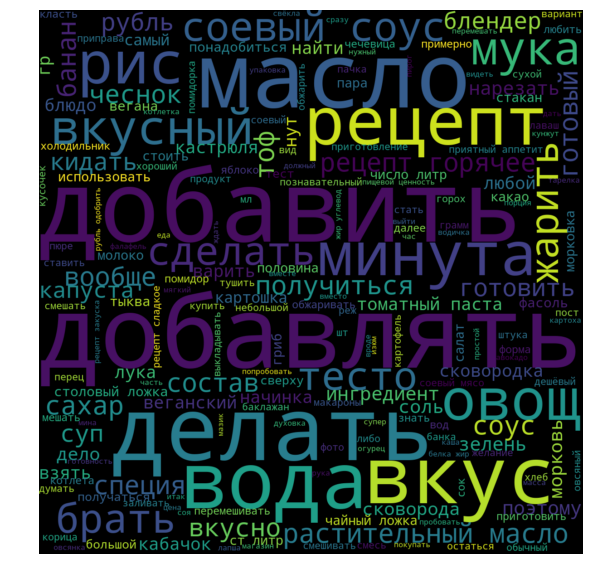

<Figure size 2160x2160 with 0 Axes>

In [34]:
generate_wordcloud(corpus)

### Сохраняем корпус

In [18]:
df = pd.DataFrame.from_dict(posts)
df_comments = pd.DataFrame.from_dict(comments)

In [19]:
df = df[['text', 'date', 'from_id', 'id', 'owner_id', 'signer_id', 'views']]

In [20]:
df_comments = df_comments[['text', 'date', 'from_id', 'id', 'owner_id']]

In [21]:
df_comments.dropna(inplace=True)
df['processed'] = df['text'].apply(tokenize)
df_comments['processed'] = df_comments['text'].apply(tokenize)
df_comments['id'] = df_comments['id'].map(int).map(str)
df_comments['from_id'] = df_comments['from_id'].map(int).map(str)
df['id'] = df['id'].map(str)
df['length'] = df['text'].apply(lambda x: len(x.split()))
df_comments['length'] = df_comments['text'].apply(lambda x: len(x.split()))

df['lemmas'] = df['text'].apply(lemmatize)
df_comments['lemmas'] = df_comments['text'].apply(lemmatize)
df.to_csv('corpus_posts_vegan.csv')
df_comments.to_csv('corpus_comments_vegan.csv')